In [1]:
import sys
import os

# Add particle_detection to sys.path
sys.path.append(os.path.abspath(".."))

In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models
from torchvision.models import ResNet18_Weights

from particle_detection.data.dataset import create_dataloaders

In [3]:
data_dir = "/home/blah-buttery/nanoparticles/images/normal"
image_size = (2048, 2048)
batch_size = 8

train_loader, test_loader = create_dataloaders(data_dir=data_dir, image_size=image_size, batch_size=batch_size)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

[INFO] Using device: cuda


In [5]:
# Pretrained VGG16 with first layer adjusted for grayscale
pretrained_encoder = models.vgg16(weights="IMAGENET1K_V1")
pretrained_encoder.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
encoder = nn.Sequential(*list(pretrained_encoder.features.children())[:-1])

# Autoencoder definition
class Autoencoder(nn.Module):
    def __init__(self, encoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),  # Output 1 channel
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the autoencoder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder = Autoencoder(encoder).to(device)
autoencoder = nn.DataParallel(autoencoder)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.0001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    for img in train_loader:
        img = img.to(device)
        
        # Forward pass
        output = autoencoder(img)
        loss = criterion(output, img)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/100], Loss: 0.0613
Epoch [2/100], Loss: 0.0544
Epoch [3/100], Loss: 0.0606
Epoch [4/100], Loss: 0.0417
Epoch [5/100], Loss: 0.0403
Epoch [6/100], Loss: 0.0594
Epoch [7/100], Loss: 0.0463
Epoch [8/100], Loss: 0.0452
Epoch [9/100], Loss: 0.0467
Epoch [10/100], Loss: 0.0390
Epoch [11/100], Loss: 0.0266
Epoch [12/100], Loss: 0.0231
Epoch [13/100], Loss: 0.0305
Epoch [14/100], Loss: 0.0281
Epoch [15/100], Loss: 0.0301
Epoch [16/100], Loss: 0.0234
Epoch [17/100], Loss: 0.0307
Epoch [18/100], Loss: 0.0173
Epoch [19/100], Loss: 0.0313
Epoch [20/100], Loss: 0.0228
Epoch [21/100], Loss: 0.0265
Epoch [22/100], Loss: 0.0222
Epoch [23/100], Loss: 0.0244
Epoch [24/100], Loss: 0.0233
Epoch [25/100], Loss: 0.0212
Epoch [26/100], Loss: 0.0254
Epoch [27/100], Loss: 0.0242
Epoch [28/100], Loss: 0.0276
Epoch [29/100], Loss: 0.0283
Epoch [30/100], Loss: 0.0242
Epoch [31/100], Loss: 0.0264
Epoch [32/100], Loss: 0.0194
Epoch [33/100], Loss: 0.0254
Epoch [34/100], Loss: 0.0221
Epoch [35/100], Loss: 0

Original image shape: torch.Size([1, 2048, 2048])
Reconstructed image shape: torch.Size([1, 2048, 2048])


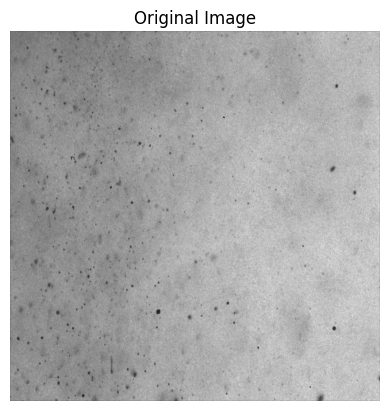

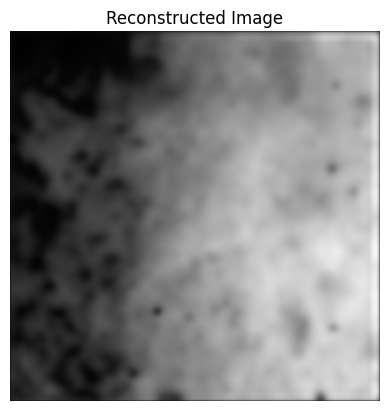

In [8]:
import matplotlib.pyplot as plt
import torch

# Forward pass sample_img through our trained model
sample_img = next(iter(test_loader))  # Get a batch of test images
sample_img = sample_img.to(device)

with torch.no_grad():
    # Unpack the tuple returned by the model
    #reconstructed_img, _, _ = vae(sample_img)
    reconstructed_img = autoencoder(sample_img)

# Handling batch dimensions to take the first image
sample_img = sample_img[0, :, :, :]  # Take the first image in the batch
print(f"Original image shape: {sample_img.shape}")
reconstructed_img = reconstructed_img[0, :, :, :]  # Match the shape for reconstruction
print(f"Reconstructed image shape: {reconstructed_img.shape}")

# Clamp values to ensure valid image range
sample_img = torch.clamp(sample_img, min=0, max=1)
reconstructed_img = torch.clamp(reconstructed_img, min=0, max=1)

# Function to display images (works for both grayscale and RGB)
def display_image(tensor, image_type="grayscale", title="Image"):
    """
    Displays an image from a PyTorch tensor.

    Args:
    - tensor (torch.Tensor): The image tensor (C, H, W).
    - image_type (str): "grayscale" for single-channel, "rgb" for multi-channel.
    - title (str): Title of the displayed image.
    """
    tensor = tensor.cpu().detach().numpy()

    if image_type == "grayscale":
        plt.imshow(tensor.squeeze(), cmap="gray")
    elif image_type == "rgb":
        # Transpose to HWC for RGB
        tensor = tensor.transpose(1, 2, 0)
        plt.imshow(tensor)
    else:
        raise ValueError(f"Invalid image_type: {image_type}. Use 'grayscale' or 'rgb'.")

    plt.axis("off")
    plt.title(title)
    plt.show()

# Display original and reconstructed images
image_type = "grayscale"  # Change to "rgb" for RGB images
display_image(sample_img, image_type=image_type, title="Original Image")
display_image(reconstructed_img, image_type=image_type, title="Reconstructed Image")

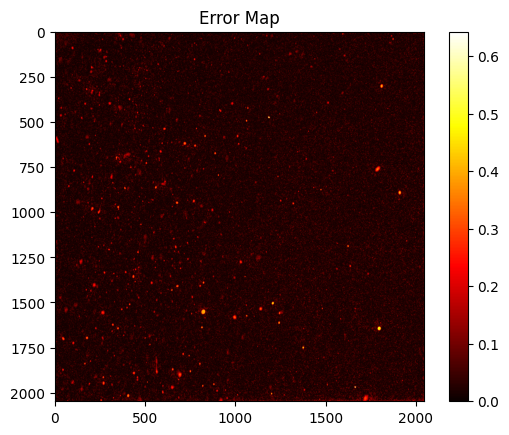

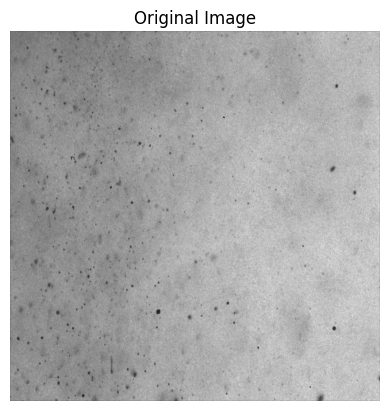

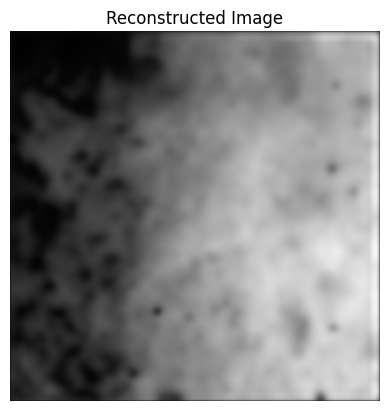

In [6]:
# Test and visualization
sample_img = next(iter(test_loader))
sample_img = sample_img.to(device)

# Forward pass sample image through the trained model
with torch.no_grad():
    reconstructed_img = autoencoder(sample_img)

reconstructed_img = torch.clamp(reconstructed_img, 0, 1)

# Error map
error_map = torch.abs(sample_img - reconstructed_img).mean(dim=1).cpu().numpy()
error_map_image = error_map[0]
plt.imshow(error_map_image, cmap="hot")
plt.colorbar()
plt.title("Error Map")
plt.show()

# Display images
def display_image(tensor, title="Image"):
    img = tensor.cpu().detach().squeeze(0).numpy()  # Remove channel dimension
    img = np.clip(img, 0, 1)  # Ensure values are in [0, 1] range
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title(title)
    plt.show()

display_image(sample_img[0], title="Original Image")
display_image(reconstructed_img[0], title="Reconstructed Image")

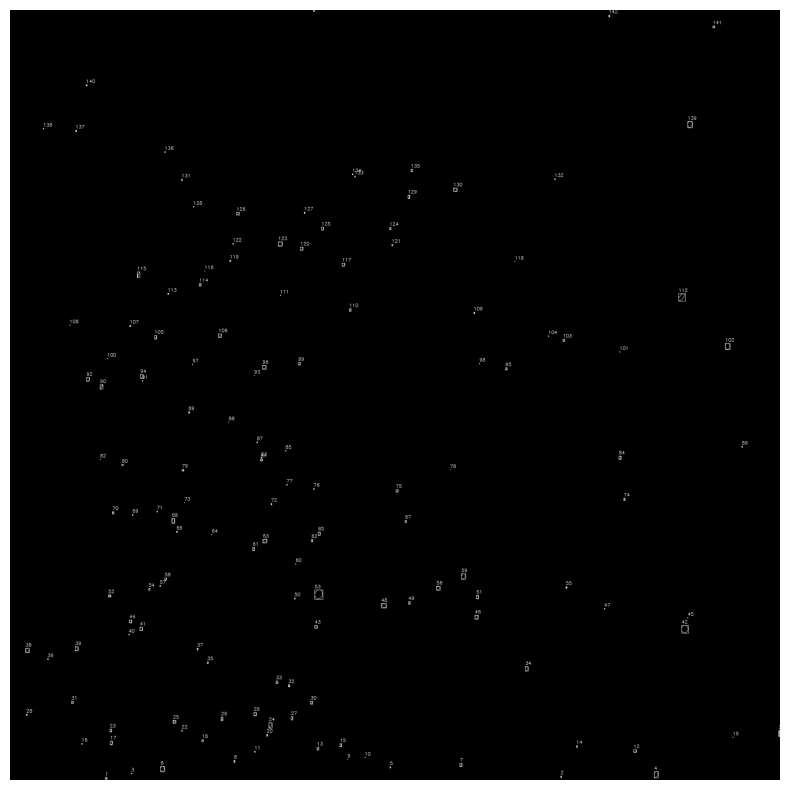

Sample_img
Number of particles: 143
Particle sizes: [12.5, 4.0, 0.5, 122.5, 2.5, 104.0, 33.0, 9.5, 0.0, 0.0, 1.0, 36.5, 18.0, 6.0, 23.0, 1.0, 41.0, 10.0, 0.0, 7.0, 25.5, 2.0, 22.0, 72.5, 31.0, 22.5, 26.5, 2.5, 36.5, 21.0, 17.0, 10.5, 15.5, 59.5, 7.0, 1.5, 5.5, 66.0, 58.5, 0.5, 38.5, 263.5, 36.0, 28.5, 0.0, 58.5, 0.5, 89.5, 21.0, 2.5, 34.5, 16.0, 375.0, 8.0, 6.0, 61.0, 1.5, 15.5, 111.5, 0.0, 22.5, 11.0, 55.5, 0.0, 32.5, 3.5, 11.5, 60.5, 1.0, 7.5, 1.5, 2.0, 0.0, 7.5, 20.5, 2.0, 1.5, 0.0, 14.0, 5.0, 14.5, 0.0, 0.0, 33.0, 1.0, 2.0, 1.5, 0.0, 5.0, 35.0, 1.0, 50.0, 0.0, 49.0, 18.0, 66.5, 0.0, 0.0, 25.0, 0.0, 0.0, 146.0, 16.0, 0.5, 33.5, 46.0, 4.0, 0.0, 4.5, 16.0, 0.0, 179.0, 4.0, 17.0, 35.0, 0.0, 36.0, 0.0, 3.0, 33.5, 5.0, 1.5, 87.5, 11.0, 29.5, 29.0, 2.5, 0.5, 27.0, 51.0, 2.0, 1.5, 0.5, 1.5, 13.0, 1.5, 5.0, 1.0, 142.5, 3.0, 11.0, 6.5, 2.5]



In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

threshold = 0.275

binary_mask = (error_map_image > threshold).astype(np.uint8)

contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

contour_image = np.zeros_like(error_map_image, dtype=np.uint8)

particle_count = 0
for i, contour in enumerate(contours):
    cv2.drawContours(contour_image, [contour], -1, (255), 1)  # Draw white contours

    # Optionally, draw bounding boxes
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(contour_image, (x, y), (x + w, y + h), (255), 1)

    # Label each particle with a number
    cv2.putText(contour_image, f"{i + 1}", (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255), 1)

    particle_count += 1

# Plot the results
plt.figure(figsize=(10, 10))
plt.imshow(contour_image, cmap="gray")
plt.axis("off")
plt.show()

particle_sizes = []
for contour in contours:
    area = cv2.contourArea(contour)
    particle_sizes.append(area)

print(f"Sample_img")
print(f"Number of particles: {len(contours)}")
print(f"Particle sizes: {particle_sizes}\n")

In [44]:
# get the latent space by passing dataset through encoder
with torch.no_grad():
    sample_img = next(iter(test_loader))
    sample_img = sample_img.to(device)
    latent_space = autoencoder.module.encoder(sample_img)
    print(f"Shape of latent space: {latent_space.shape}")

Shape of latent space: torch.Size([3, 512, 128, 128])


In [45]:
latent_space_reshaped = latent_space.permute(0, 2, 3, 1).reshape(-1, latent_space.shape[1])  # Shape: [N, C]
print(f"Shape of reshaped latent space: {latent_space_reshaped.shape}")

Shape of reshaped latent space: torch.Size([49152, 512])


In [46]:
from sklearn.mixture import GaussianMixture

# apply initial gmm clustering
gmm = GaussianMixture(n_components=5, random_state=42, covariance_type="full")
gmm.fit(latent_space_reshaped.cpu().numpy())
cluster_labels = gmm.predict(latent_space_reshaped.cpu().numpy())

/home/blah-buttery/particle_detection/.venv/lib/python3.10/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


In [47]:
# Map Cluster Labels Back to Spatial Grid
grid_cols = latent_space.shape[3]  # 1024 / 8 = 128
grid_rows = latent_space.shape[2]  # 1024 / 8 = 128
cluster_labels_grid = cluster_labels.reshape(latent_space.shape[0], grid_rows, grid_cols)  # Shape: [B, H, W]

print(f"Cluster labels grid shape: {cluster_labels_grid.shape}")

Cluster labels grid shape: (3, 128, 128)


In [48]:
def visualize_clusters_on_image(image_batch, cluster_labels_grid):
    """
    Visualize clusters directly on the spatial grid of the image.
    
    Args:
        image_batch (torch.Tensor): Batch of images, shape [B, C, H, W].
        cluster_labels_grid (np.ndarray): Cluster labels, shape [B, H, W].
    
    Returns:
        None
    """
    # Select the first image and its cluster labels
    single_image = image_batch[0]  # Shape: [C, H, W]
    single_cluster_labels = cluster_labels_grid[0]  # Shape: [H, W]

    # Visualize the image and clusters
    plt.figure(figsize=(12, 6))

    # Original Image
    plt.subplot(1, 2, 1)
    image_np = single_image.cpu().numpy().transpose(1, 2, 0)  # Convert CHW to HWC
    if image_np.max() > 1.0:
        image_np = image_np / 255.0  # Normalize
    plt.imshow(image_np, cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    # Cluster Overlay
    plt.subplot(1, 2, 2)
    plt.imshow(single_cluster_labels, cmap="viridis")
    plt.title("Cluster Visualization")
    plt.colorbar(label="Cluster")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

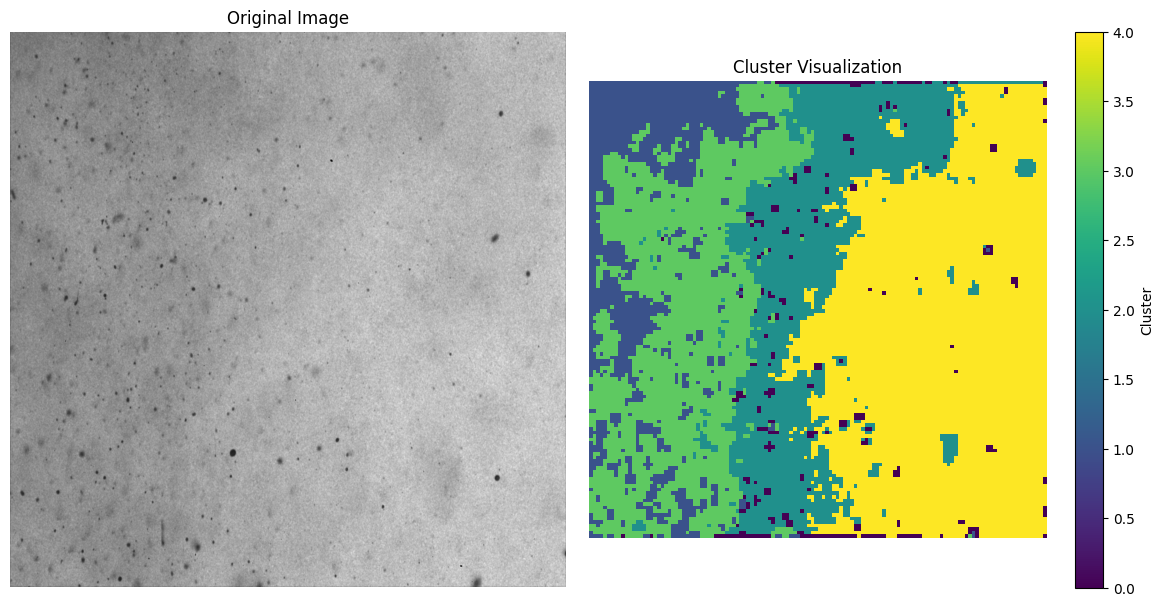

In [49]:
visualize_clusters_on_image(sample_img, cluster_labels_grid)

In [50]:
# okay, but can we improve the results?
# we can do this if we elimante some of the least important channels of the latent space
from sklearn.decomposition import PCA

# Convert PyTorch tensor to NumPy array
latent_space_np = latent_space_reshaped.cpu().numpy()  # Shape: [8192, 512]

# Apply PCA
n_components = 50  # Adjust based on your needs (e.g., explained variance)
pca = PCA(n_components=n_components)
latent_space_pca = pca.fit_transform(latent_space_np)  # Shape: [8192, 50]

print(f"Shape after PCA: {latent_space_pca.shape}")

Shape after PCA: (49152, 50)


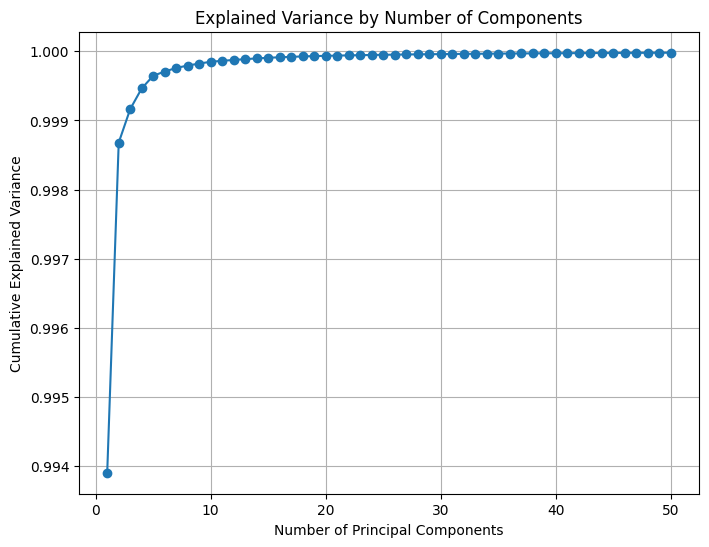

In [51]:
# Plot the explained variance
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by Number of Components")
plt.grid()
plt.show()

In [52]:
pca = PCA(n_components=8)
latent_space_pca = pca.fit_transform(latent_space_np)  # Shape: [8192, 20]
print(f"Shape after PCA: {latent_space_pca.shape}")

Shape after PCA: (49152, 8)


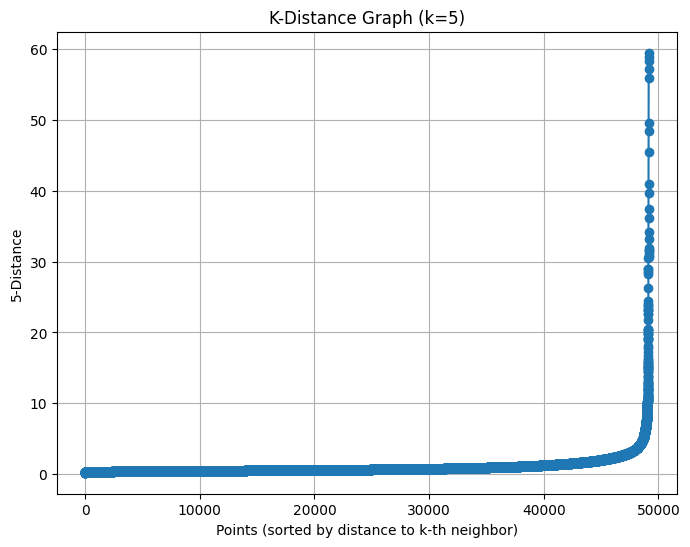

In [24]:
from sklearn.neighbors import NearestNeighbors

def plot_k_distance(data, k=5):
    """
    Plots the k-distance graph to help select the `eps` parameter for DBSCAN.
    
    Args:
        data (np.ndarray): Data for DBSCAN, shape [N, features].
        k (int): The k-th nearest neighbor to calculate distances for.
    
    Returns:
        None (plots the k-distance graph).
    """
    # Fit Nearest Neighbors model
    nbrs = NearestNeighbors(n_neighbors=k).fit(data)
    
    # Find distances to the k-th nearest neighbor for each point
    distances, _ = nbrs.kneighbors(data)
    
    # Extract the k-th nearest neighbor distances (column `k-1`)
    k_distances = np.sort(distances[:, k-1])  # Sort distances in ascending order
    
    # Plot the sorted k-distances
    plt.figure(figsize=(8, 6))
    plt.plot(k_distances, marker='o')
    plt.title(f"K-Distance Graph (k={k})")
    plt.xlabel("Points (sorted by distance to k-th neighbor)")
    plt.ylabel(f"{k}-Distance")
    plt.grid()
    plt.show()

# Example Usage:
latent_space_np = latent_space_reshaped.cpu().numpy()  # Ensure latent space is in NumPy format
plot_k_distance(latent_space_pca, k=5)  # Set k = min_samples - 1

In [54]:
gmm = GaussianMixture(n_components=3, random_state=42, covariance_type="full")
gmm.fit(latent_space_pca)  # Fit on reshaped latent space
cluster_labels = gmm.predict(latent_space_pca)  # Shape: [N]

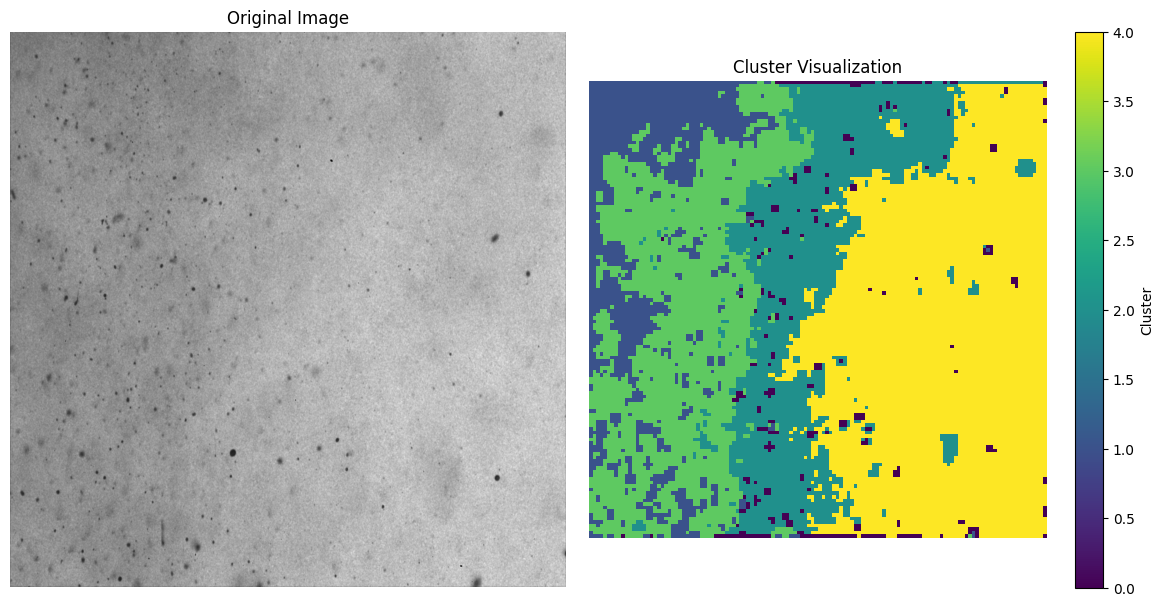

In [55]:
visualize_clusters_on_image(sample_img, cluster_labels_grid)

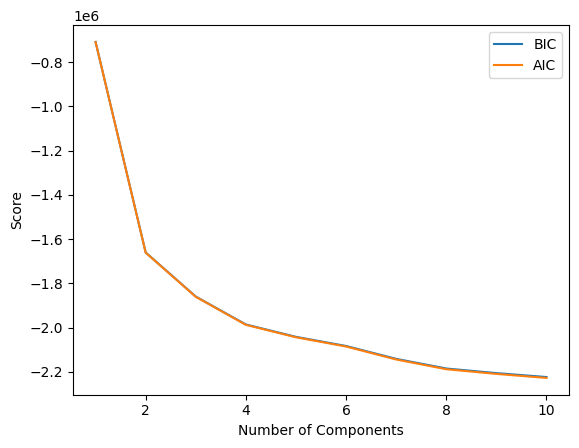

In [53]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

n_components_range = range(1, 11)
bic = []
aic = []

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(latent_space_pca)  # Replace 'data' with your dataset
    bic.append(gmm.bic(latent_space_pca))
    aic.append(gmm.aic(latent_space_pca))

plt.plot(n_components_range, bic, label="BIC")
plt.plot(n_components_range, aic, label="AIC")
plt.xlabel("Number of Components")
plt.ylabel("Score")
plt.legend()
plt.show()


Unique cluster labels: [0 1 2 3 4]


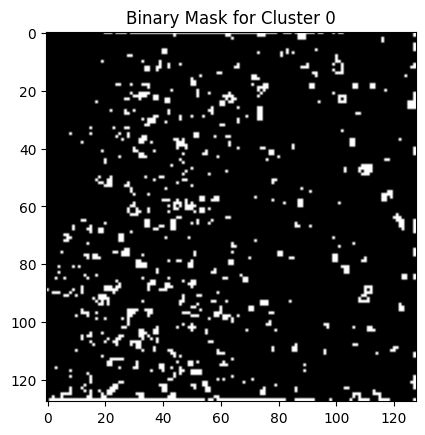

Cluster 0: Found 320 contours.


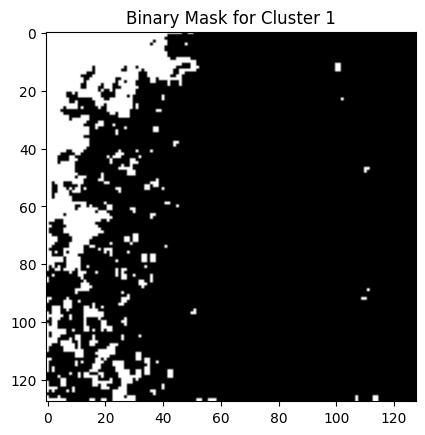

Cluster 1: Found 93 contours.


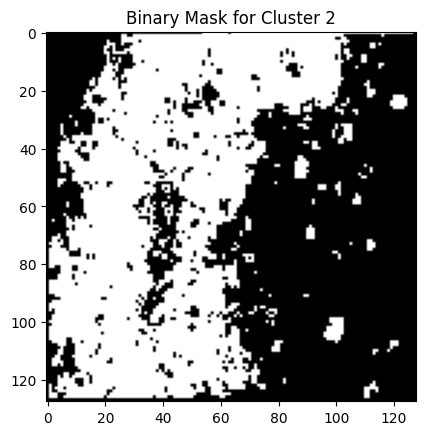

Cluster 2: Found 63 contours.


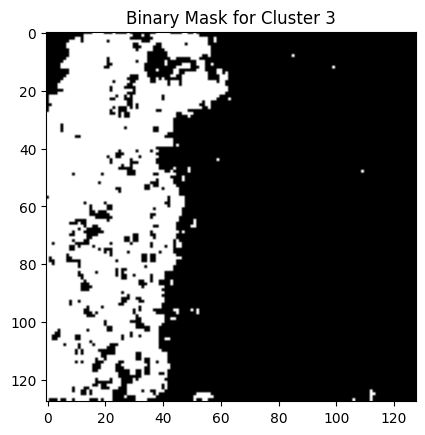

Cluster 3: Found 23 contours.


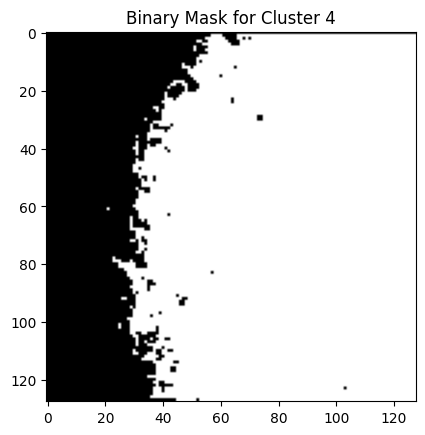

Cluster 4: Found 11 contours.


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

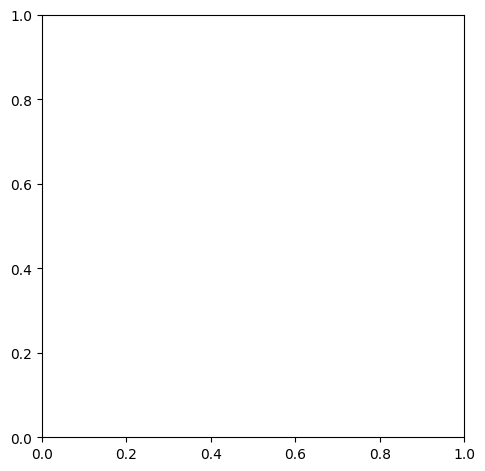

In [56]:
# Debug: Check cluster labels
print(f"Unique cluster labels: {np.unique(cluster_labels_grid)}")

image_np = sample_img[0].cpu().numpy().transpose(1, 2, 0)
visualized_img = image_np.copy()  # Create a copy for visualization

# Iterate over unique clusters
for cluster in np.unique(cluster_labels_grid):
    # Create a binary mask for the current cluster
    cluster_mask = (cluster_labels_grid == cluster).astype(np.uint8)
    
    if cluster_mask.ndim == 3:
        cluster_mask = np.sum(cluster_mask, axis=0)
    cluster_mask = (cluster_mask > 0).astype(np.uint8)
    
    # Debug: Visualize the binary mask
    plt.imshow(cluster_mask, cmap='gray')
    plt.title(f"Binary Mask for Cluster {cluster}")
    plt.show()

    # Find contours
    contours, _ = cv2.findContours(cluster_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Cluster {cluster}: Found {len(contours)} contours.")

    # Draw the contours on the visualization image
    cv2.drawContours(visualized_img, contours, -1, (255, 0, 0), 2)

# Visualize results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(sample_img, cmap='gray')
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(visualized_img, cmap='gray')
plt.title("Particles Visualized")
plt.axis("off")

plt.tight_layout()
plt.show()

In [57]:
def visualize_single_cluster(sample_img, cluster_labels_grid, cluster_to_visualize, scale_factor=16):
    """
    Visualizes a single cluster on the image.

    Args:
        sample_img (torch.Tensor): The image tensor of shape [1, C, H, W].
        cluster_labels_grid (np.ndarray): The cluster labels grid of shape [B, H, W].
        cluster_to_visualize (int): The specific cluster to visualize.
        scale_factor (int): Scaling factor to map latent space coordinates to original image coordinates.
    
    Returns:
        None: Displays the image with the selected cluster highlighted.
    """
    print(f"Processing cluster: {cluster_to_visualize}")
    
    # Convert `sample_img` to NumPy for visualization
    image_np = sample_img[0].cpu().numpy().transpose(1, 2, 0)  # Convert CHW to HWC
    image_with_cluster = image_np.copy()
    
    # Extract all coordinates for the specified cluster
    coords = np.argwhere(cluster_labels_grid[0] == cluster_to_visualize)  # Get coordinates (row, col)
    print(f"Cluster {cluster_to_visualize}: {len(coords)} points found.")
    
    # Map the coordinates to the original image dimensions
    for coord in coords:
        y, x = coord * scale_factor  # Scale to original dimensions
        # Draw a small rectangle (just around the coordinate)
        cv2.rectangle(
            image_with_cluster,
            (x, y),
            (x + 1, y + 1),  # A box of size 1x1 pixel
            (255, 0, 0),  # Red color in BGR
            thickness=1  # Thickness of the rectangle
        )
    
    # Visualize the Image with Highlighted Cluster
    plt.figure(figsize=(12, 12))
    plt.imshow(image_with_cluster, cmap="gray")
    plt.title(f"Cluster {cluster_to_visualize} Highlighted")
    plt.axis("off")
    plt.show()

In [61]:
def visualize_single_cluster(sample_img, cluster_labels_grid, cluster_to_visualize, scale_factor=16):
    """
    Visualizes a single cluster on a grayscale image.

    Args:
        sample_img (torch.Tensor): The grayscale image tensor of shape [1, 1, H, W].
        cluster_labels_grid (np.ndarray): The cluster labels grid of shape [B, H, W].
        cluster_to_visualize (int): The specific cluster to visualize.
        scale_factor (int): Scaling factor to map latent space coordinates to original image coordinates.
    
    Returns:
        None: Displays the image with the selected cluster highlighted.
    """
    print(f"Processing cluster: {cluster_to_visualize}")
    
    # Convert `sample_img` to NumPy for visualization
    image_np = sample_img[0, 0].cpu().numpy()  # Convert to 2D array (H, W)
    image_with_cluster = np.stack([image_np] * 3, axis=-1)  # Convert grayscale to RGB for visualization
    
    # Extract all coordinates for the specified cluster
    coords = np.argwhere(cluster_labels_grid[0] == cluster_to_visualize)  # Get coordinates (row, col)
    print(f"Cluster {cluster_to_visualize}: {len(coords)} points found.")
    
    # Map the coordinates to the original image dimensions
    for coord in coords:
        y, x = coord * scale_factor  # Scale to original dimensions
        # Draw a small rectangle (just around the coordinate)
        cv2.rectangle(
            image_with_cluster,
            (x, y),
            (x + 1, y + 1),  # A box of size 1x1 pixel
            (255, 0, 0),  # Red color in BGR (converted to RGB)
            thickness=1  # Thickness of the rectangle
        )
    
    # Visualize the Image with Highlighted Cluster
    plt.figure(figsize=(12, 12))
    plt.imshow(image_with_cluster, cmap="gray")
    plt.title(f"Cluster {cluster_to_visualize} Highlighted")
    plt.axis("off")
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Processing cluster: 0
Cluster 0: 328 points found.


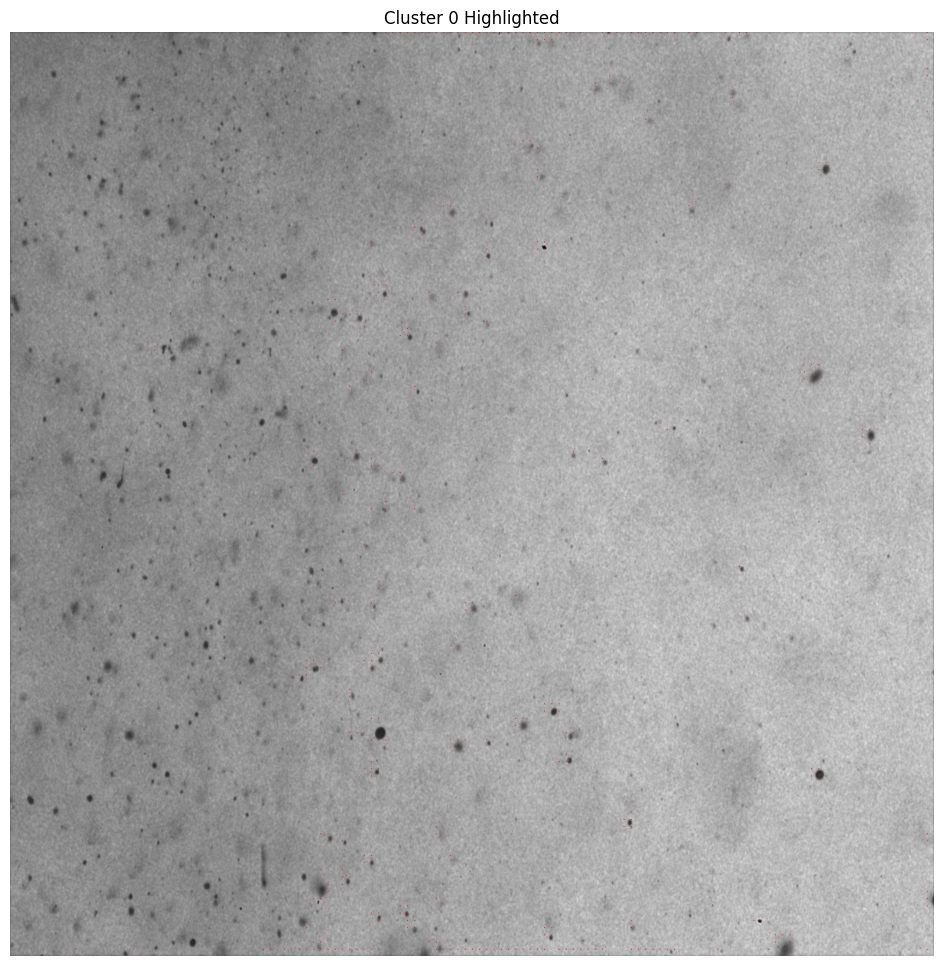

In [62]:
cluster_to_visualize = 0  # Specify the cluster you want to visualize
visualize_single_cluster(sample_img, cluster_labels_grid, cluster_to_visualize, scale_factor=16)

In [38]:
import torch
import torch.nn as nn

class CustomEncoder(nn.Module):
    def __init__(self):
        super(CustomEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),  # Grayscale input, 64 filters
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Downsample: (H, W) -> (H/2, W/2)

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # 128 filters
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Downsample: (H/2, W/2) -> (H/4, W/4)

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # 256 filters
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Downsample: (H/4, W/4) -> (H/8, W/8)

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),  # 512 filters
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Downsample: (H/8, W/8) -> (H/16, W/16)
        )

    def forward(self, x):
        x = self.encoder(x)
        return x


In [39]:
class Autoencoder(nn.Module):
    def __init__(self, encoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # Upsample
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),  # Output 1 channel for grayscale
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Instantiate the custom encoder and autoencoder
encoder = CustomEncoder()
autoencoder = Autoencoder(encoder)

In [42]:
# Initialize the autoencoder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder = Autoencoder(encoder).to(device)
autoencoder = nn.DataParallel(autoencoder)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    for img in train_loader:
        img = img.to(device)
        
        # Forward pass
        output = autoencoder(img)
        loss = criterion(output, img)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/100], Loss: 0.0627
Epoch [2/100], Loss: 0.0512
Epoch [3/100], Loss: 0.0468
Epoch [4/100], Loss: 0.0942
Epoch [5/100], Loss: 0.0423
Epoch [6/100], Loss: 0.0430
Epoch [7/100], Loss: 0.0561
Epoch [8/100], Loss: 0.0634
Epoch [9/100], Loss: 0.0300
Epoch [10/100], Loss: 0.0556
Epoch [11/100], Loss: 0.0471
Epoch [12/100], Loss: 0.0545
Epoch [13/100], Loss: 0.0463
Epoch [14/100], Loss: 0.0655
Epoch [15/100], Loss: 0.0567
Epoch [16/100], Loss: 0.0549
Epoch [17/100], Loss: 0.0389
Epoch [18/100], Loss: 0.0527
Epoch [19/100], Loss: 0.0525
Epoch [20/100], Loss: 0.0483
Epoch [21/100], Loss: 0.0537
Epoch [22/100], Loss: 0.0338
Epoch [23/100], Loss: 0.0390
Epoch [24/100], Loss: 0.0571
Epoch [25/100], Loss: 0.0463
Epoch [26/100], Loss: 0.0472
Epoch [27/100], Loss: 0.0582
Epoch [28/100], Loss: 0.0546
Epoch [29/100], Loss: 0.0535
Epoch [30/100], Loss: 0.0536
Epoch [31/100], Loss: 0.0654
Epoch [32/100], Loss: 0.0517
Epoch [33/100], Loss: 0.0538
Epoch [34/100], Loss: 0.0318
Epoch [35/100], Loss: 0

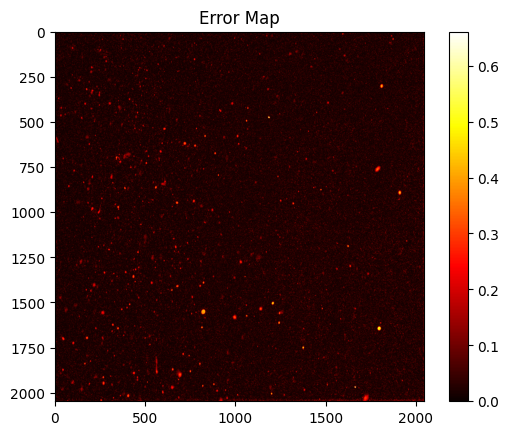

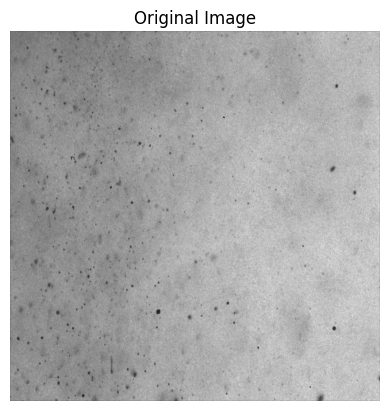

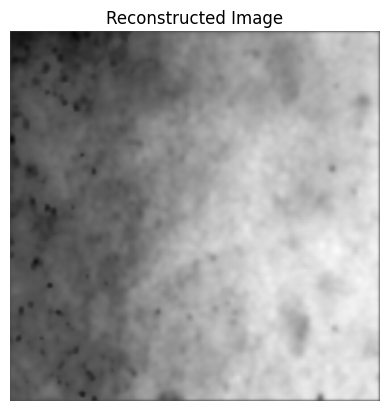

In [43]:
# Test and visualization
sample_img = next(iter(test_loader))
sample_img = sample_img.to(device)

# Forward pass sample image through the trained model
with torch.no_grad():
    reconstructed_img = autoencoder(sample_img)

reconstructed_img = torch.clamp(reconstructed_img, 0, 1)

# Error map
error_map = torch.abs(sample_img - reconstructed_img).mean(dim=1).cpu().numpy()
error_map_image = error_map[0]
plt.imshow(error_map_image, cmap="hot")
plt.colorbar()
plt.title("Error Map")
plt.show()

# Display images
def display_image(tensor, title="Image"):
    img = tensor.cpu().detach().squeeze(0).numpy()  # Remove channel dimension
    img = np.clip(img, 0, 1)  # Ensure values are in [0, 1] range
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title(title)
    plt.show()

display_image(sample_img[0], title="Original Image")
display_image(reconstructed_img[0], title="Reconstructed Image")